<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# Resampling 

Resampling data is a very common operation when building a Modflow model. Usually it is used to project data from one grid onto the other. There are many different ways to do this. This notebook shows some examples of resampling methods that are incorporated in the `nlmod` package. These methods rely heavily on resampling methods in other packages such as `scipy.interpolate` and `xarray`.

### Contents<a name="TOC"></a>
1. [Grid types](#gridtypes)
2. [Structured grid to fine structured grid](#2)
3. [Structured grid to locally refined grid](#3)
4. [Locally refined grid to structured grid](#4)
5. [Fill nan values](#5)
6. [Vector to grid](#6)

In [1]:
import nlmod
from nlmod.mdims import resample
import numpy as np
import xarray as xr
import flopy

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely.geometry import Polygon as shp_polygon
from scipy.interpolate import RectBivariateSpline
import logging

from IPython.display import display

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.2.4b


### [1. Grid types](#TOC)<a name="gridtypes"></a>

So far two different gridtypes are supported in `nlmod`:
- structured grids where the cellsize is fixed for all cells
- vertex grids where the cellsize differs locally. These grids are usually created using local grid refinement algorithms.

In this notebook we define a few xarray dataarray of structured and vertex grids. We use these grids in the next chapter to show the resampling functions in `nlmod`.

#### structured grid 1

This structured grid has random numbers between 0 and 9. Has 10 x 10 cells.

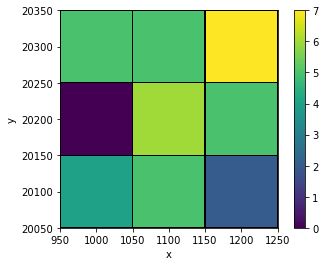

In [3]:
# structured grid 2d
x = np.arange(1000, 1300, 100)
y = np.arange(20300, 20000, -100)
data_2d = np.random.randint(0, 10, size=(len(y), len(x)))
struc2d = xr.DataArray(data_2d, dims=('y', 'x'),
                       coords={'x': x,
                               'y': y})
fig, ax = plt.subplots()
ax.set_aspect('equal')
qm = struc2d.plot(ax=ax, lw=0.1, edgecolor='k')


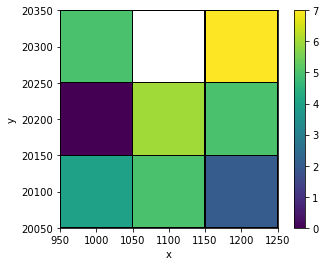

In [4]:
# structured grid 2d with nan value
struc2d_nan = struc2d.copy().astype(float)
struc2d_nan.values[0][1] = np.nan
fig, ax = plt.subplots()
ax.set_aspect('equal')
qm = struc2d_nan.plot(ax=ax, lw=0.1, edgecolor='k')


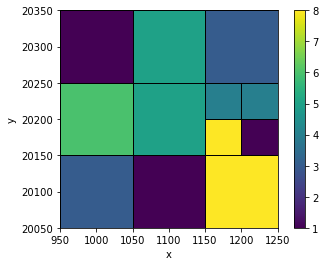

In [5]:
# vertex grid 1
dx = 100
dy = 100
x = np.arange(1000, 1300, dx)
y = np.arange(20300, 20000, -dy)
split_cell_no = 5

# create structured grid
xv, yv = np.meshgrid(x, y)
xvc = xv.ravel()
yvc = yv.ravel()
#xyi = np.stack((np.ravel(xv), np.ravel(yv)), axis=-1)

# create vertices
vertices = np.ones((len(xvc), 4, 2))
for i, x, y in zip(range(len(vertices)),xvc, yvc):
    vertices[i] = np.array([[x-(dx/2), y+(dy/2)],
                            [x+(dx/2), y+(dy/2)],
                            [x+(dx/2), y-(dy/2)],
                            [x-(dx/2), y-(dy/2)]])
    
# remove refined cell from structured grid
split_cell_x, split_cell_y = xvc[split_cell_no], yvc[split_cell_no]
xvc = np.delete(xvc, split_cell_no, 0)
yvc = np.delete(yvc, split_cell_no, 0)
vertices = np.delete(vertices, split_cell_no, 0)

# get cell centers of refined cell
x_refined = np.array([split_cell_x-(dx/4), split_cell_x+(dx/4), split_cell_x-(dx/4), split_cell_x+(dx/4)])
y_refined = np.array([split_cell_y+(dy/4), split_cell_y+(dy/4), split_cell_y-(dy/4), split_cell_y-(dy/4)])

# get vertices of refined cell
vert_refined = np.ones((len(x_refined), 4, 2))
for i, x, y in zip(range(len(vert_refined)),x_refined, y_refined):
    vert_refined[i] = np.array([[x-(dx/4), y+(dy/4)],
                                [x+(dx/4), y+(dy/4)],
                                [x+(dx/4), y-(dy/4)],
                                [x-(dx/4), y-(dy/4)]])

# add refined cell to the grid and vertices
xvc = np.insert(xvc, split_cell_no, x_refined, axis=0)
yvc = np.insert(yvc, split_cell_no, y_refined, axis=0)
vertices = np.insert(vertices, split_cell_no, vert_refined, axis=0)

# get cellid
icell2d = np.arange(len(xvc))

# create values
values = np.random.randint(0, 10, size=len(icell2d))

# create vertextured dataarray
vertex1 = xr.DataArray(values, dims=('icell2d'),
                       coords={'icell2d': icell2d})
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, gridkwargs={'edgecolor': 'k'});

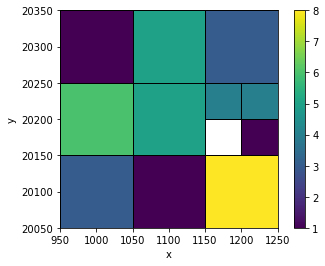

In [6]:
# vertextured grid 2 with nan
vertex1_nan = vertex1.copy().astype(float)
vertex1_nan.values[7] = np.nan

nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max());

## [2 Structured grid to fine structured grid](#TOC)<a name="2"></a>

In [7]:
# new grid dimensions
xmid = np.arange(950, 1300, 50)
ymid = np.arange(20350, 20000, -50)

### nearest

Text(0.5, 1.0, 'resampled grid')

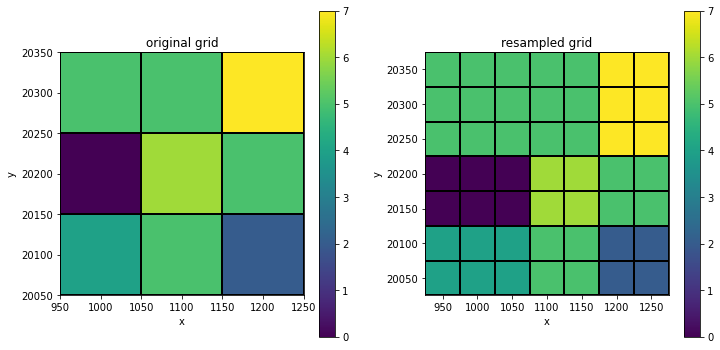

In [8]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, x=xmid, y=ymid,
                                                             kind='nearest')
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

#### nearest with nan values

Text(0.5, 1.0, 'resampled grid')

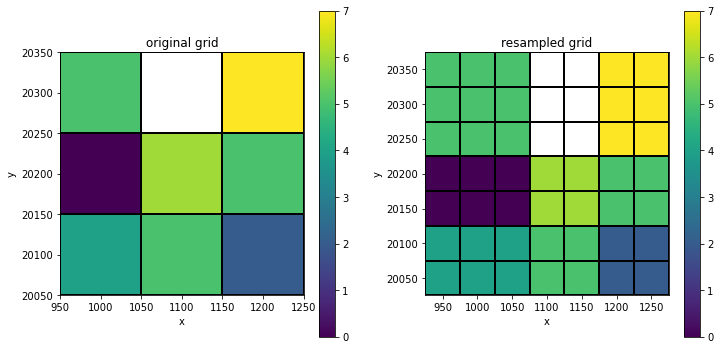

In [9]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d_nan, x=xmid, y=ymid,
                                                             kind='nearest')
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### linear

Text(0.5, 1.0, 'resampled grid')

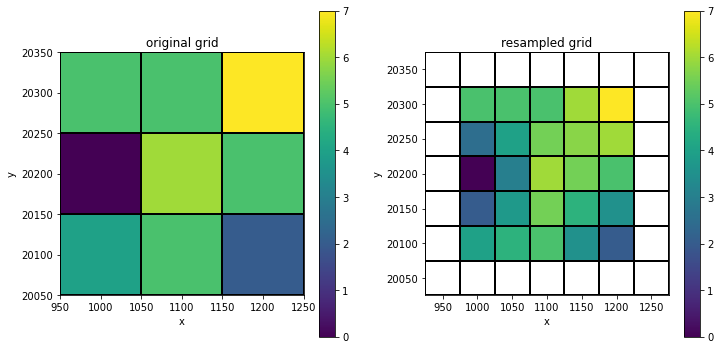

In [10]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, x=xmid, y=ymid,
                                                             kind='linear', fill_value=np.nan)
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

Text(0.5, 1.0, 'resampled grid')

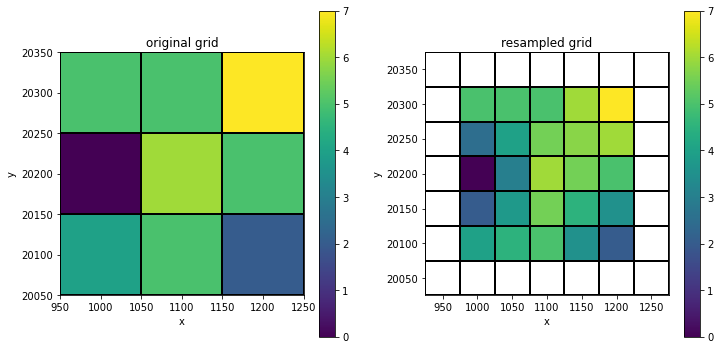

In [11]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, x=xmid, y=ymid,
                                                             kind='linear', fill_value=np.nan)
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### linear with nans in input

Text(0.5, 1.0, 'resampled grid')

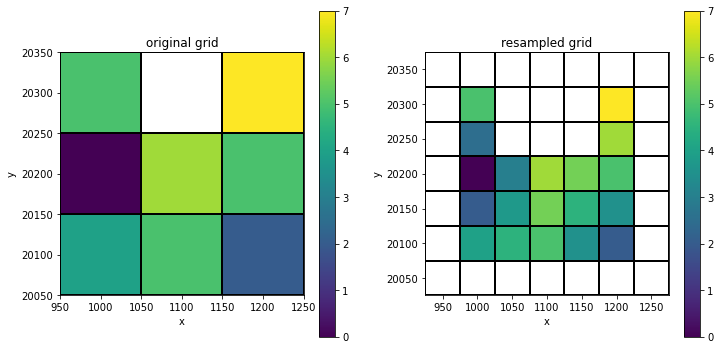

In [12]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d_nan, x=xmid, y=ymid,
                                                             kind='linear', fill_value=np.nan)
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k', vmin=0)
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k', vmin=0)
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Cubic

Text(0.5, 1.0, 'resampled grid')

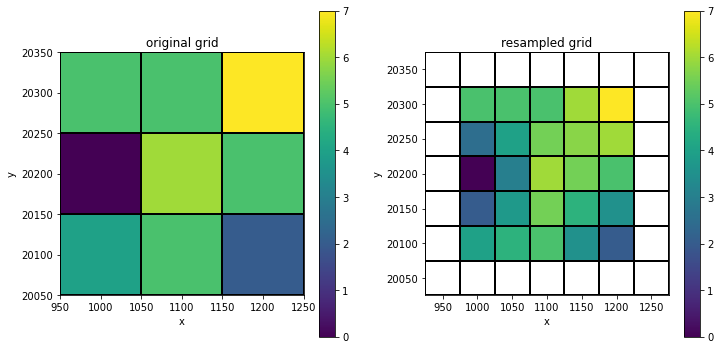

In [13]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, x=xmid, y=ymid,
                                                           kind='cubic', fill_value=np.nan)

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Cubic with nans in input

Text(0.5, 1.0, 'resampled grid')

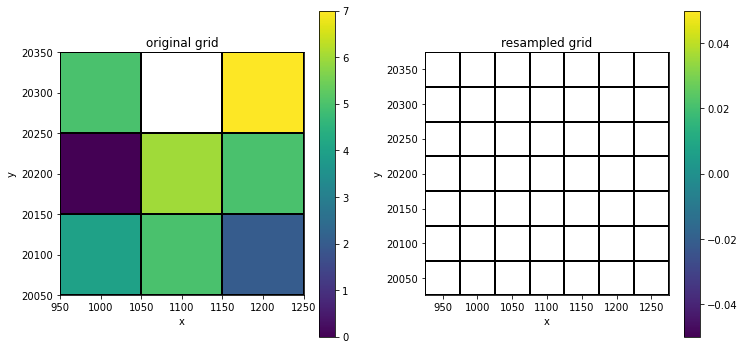

In [14]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d_nan, x=xmid, y=ymid,
                                                           kind='cubic')

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Rectangular Bivariate Spline (not yet included in nlmod)

Text(0.5, 1.0, 'resampled grid')

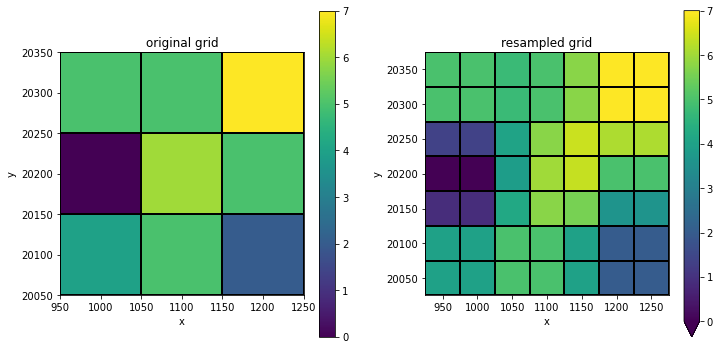

In [15]:
interp_spline = RectBivariateSpline(struc2d.x.values, struc2d.y.values[::-1], struc2d.values[::-1], 
                                    ky=min(3,len(struc2d.y)-1), 
                                    kx=min(3,len(struc2d.x)-1))
arr_out = interp_spline(xmid, ymid[::-1], grid=True)[::-1]
struc_out = xr.DataArray(arr_out, dims=('y', 'x'),
                         coords={'x': xmid,
                                 'y': ymid})

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k', vmin=0)
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Rectangular Bivariate Spline with nans (not yet included in nlmod)

Text(0.5, 1.0, 'resampled grid')

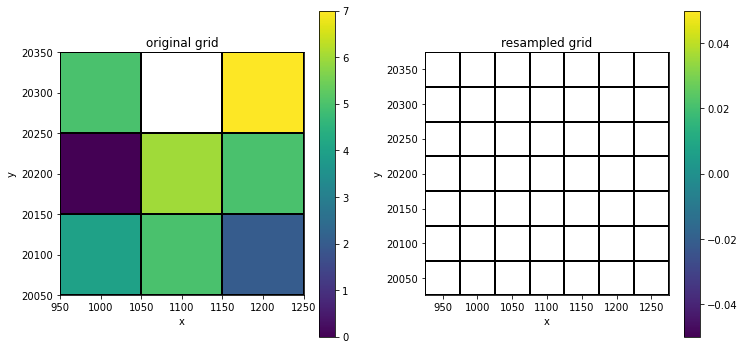

In [16]:
interp_spline = RectBivariateSpline(struc2d_nan.x.values, struc2d_nan.y.values[::-1], struc2d_nan.values[::-1], 
                                    ky=min(3,len(struc2d_nan.y)-1), 
                                    kx=min(3,len(struc2d_nan.x)-1))
interp_spline = RectBivariateSpline(struc2d_nan.x.values, struc2d_nan.y.values[::-1], struc2d_nan.values[::-1], 
                                    ky=min(3,len(struc2d_nan.y)-1), 
                                    kx=min(3,len(struc2d_nan.x)-1))
arr_out = interp_spline(xmid, ymid[::-1], grid=True)[::-1]
struc_out = xr.DataArray(arr_out, dims=('y', 'x'),
                         coords={'x': xmid,
                                 'y': ymid})

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

## [3. Structured grid to locally refined grid](#TOC)<a name="3"></a>



#### Nearest

In [17]:
res_vertex2d_n = resample.resample_dataarray2d_to_vertex_grid(struc2d, x=xvc, y=yvc, icell2d=icell2d)

Text(0.5, 1.0, 'locally refined grid')

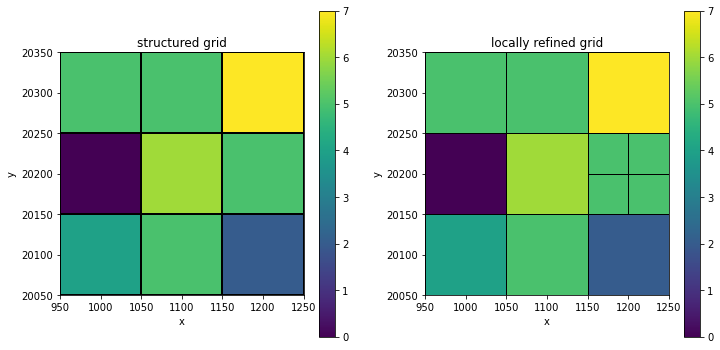

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('structured grid')
nlmod.visualise.plots.plot_vertex_array(res_vertex2d_n, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'})
axes[1].set_title('locally refined grid')

#### Linear

In [19]:
res_vertex2d_l = resample.resample_dataarray2d_to_vertex_grid(struc2d, x=xvc, y=yvc, icell2d=icell2d, method='linear')

Text(0.5, 1.0, 'locally refined grid')

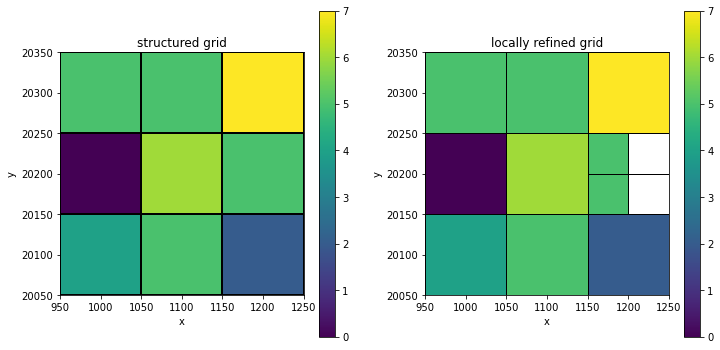

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('structured grid')
nlmod.visualise.plots.plot_vertex_array(res_vertex2d_l, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'}, vmin=struc2d.min(), vmax=struc2d.max())
axes[1].set_title('locally refined grid')

#### Cubic

In [21]:
res_vertex2d_c = resample.resample_dataarray2d_to_vertex_grid(struc2d, x=xvc, y=yvc, icell2d=icell2d, method='cubic')

Text(0.5, 1.0, 'locally refined grid')

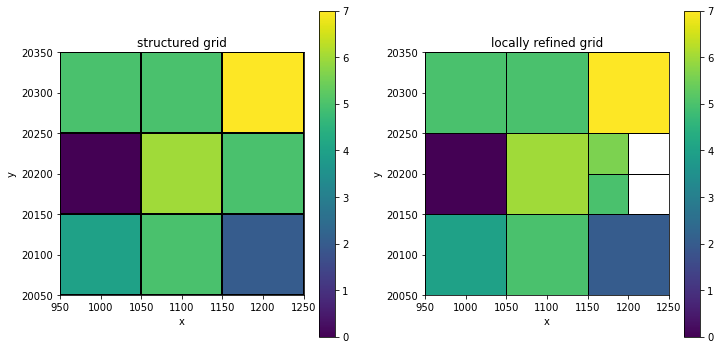

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('structured grid')
nlmod.visualise.plots.plot_vertex_array(res_vertex2d_c, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'}, vmin=struc2d.min(), vmax=struc2d.max())
axes[1].set_title('locally refined grid')

## [4. Locally refined grid to structured grid](#TOC)<a name="4"></a>



#### nearest

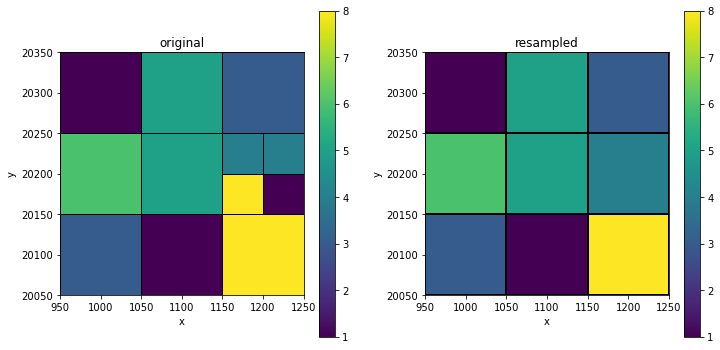

In [23]:
struc_out_n = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1, x=xvc, y=yvc, cellsize=100,
                                                            method='nearest')

# plot
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'})
axes[0].set_title('original')
struc_out_n.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

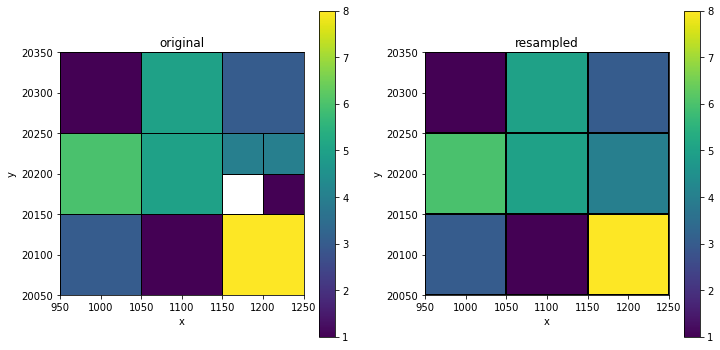

In [24]:
struc_out_nan_n = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1_nan, x=xvc, y=yvc, cellsize=100,
                                                              method='nearest')

# plot
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max())
axes[0].set_title('original')
struc_out_nan_n.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

### linear

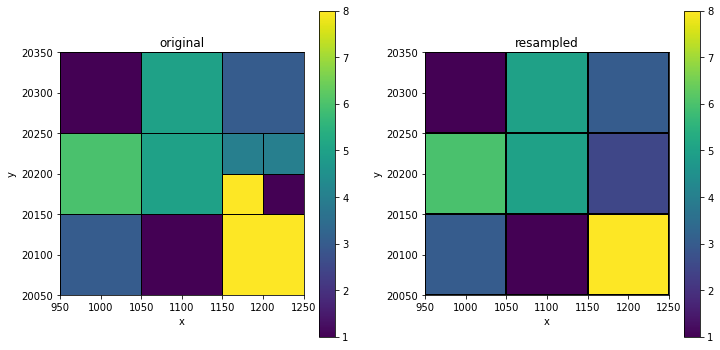

In [25]:
struc_out_l = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1, x=xvc, y=yvc, cellsize=100,
                                                            method='linear')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'})
axes[0].set_title('original')
struc_out_l.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

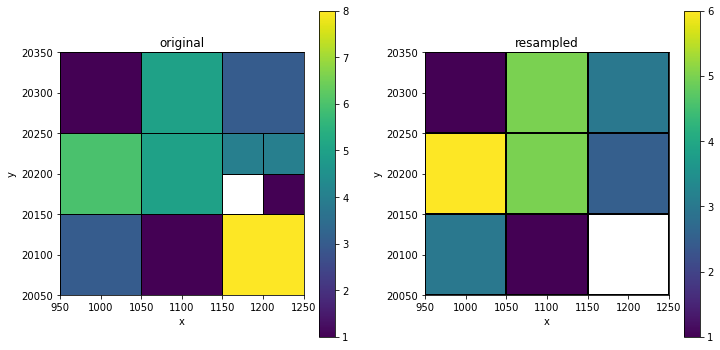

In [26]:
struc_out_l_nan = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1_nan, x=xvc, y=yvc, cellsize=100,
                                                                method='linear')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max())
axes[0].set_title('original')
struc_out_l_nan.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

### cubic

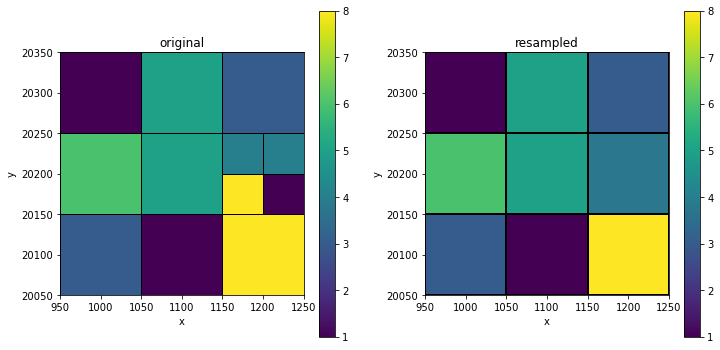

In [27]:
struc_out_c = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1, x=xvc, y=yvc, cellsize=100,
                                                            method='cubic')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'})
axes[0].set_title('original')
struc_out_c.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

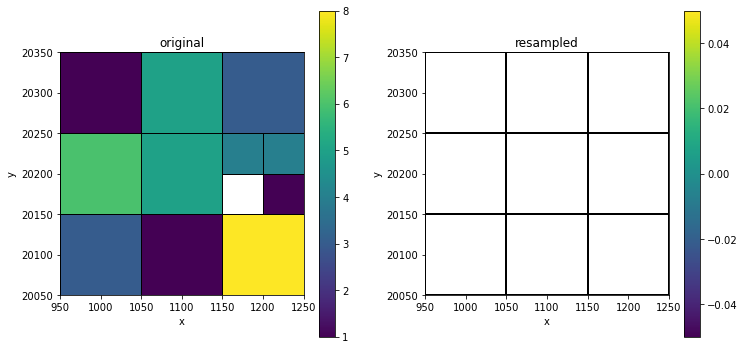

In [28]:
struc_out_c_nan = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1_nan, x=xvc, y=yvc, cellsize=100,
                                                                method='cubic')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max())
axes[0].set_title('original')
struc_out_c_nan.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

## [5. Fill nan values](#TOC)<a name="5"></a>



## Structured grid

### nearest

In [29]:
struc2d_nan_filled = resample.fillnan_dataarray_structured_grid(struc2d_nan, method='nearest')

Text(0.5, 1.0, 'resampled')

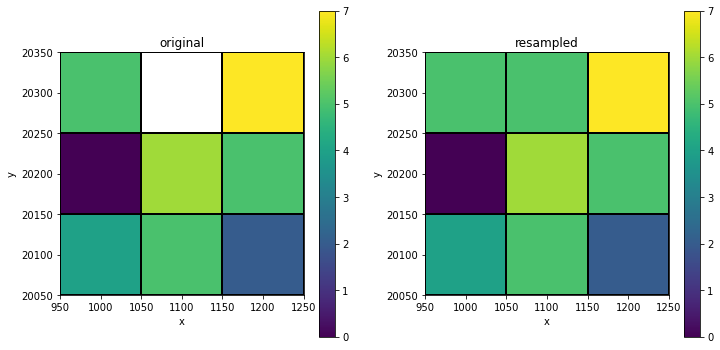

In [30]:
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original')
struc2d_nan_filled.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled')

### linear

In [31]:
struc2d_nan_filled_lin = resample.fillnan_dataarray_structured_grid(struc2d_nan, method='linear')

Text(0.5, 1.0, 'resampled')

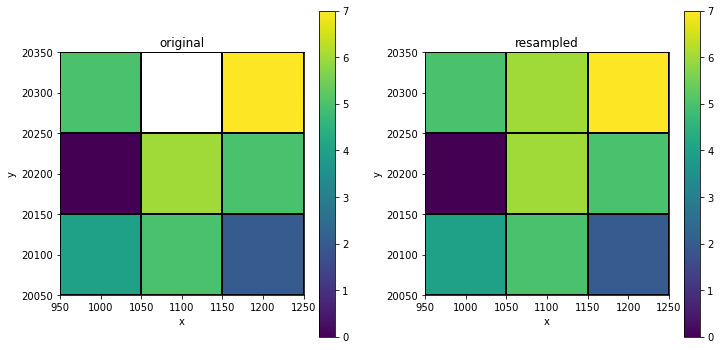

In [32]:
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original')
struc2d_nan_filled_lin.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled')

## vertex grid

### nearest

In [33]:
vertex1_nan_filled = resample.fillnan_dataarray_vertex_grid(vertex1_nan, x=xvc, y=yvc, icell2d=vertex1_nan.icell2d, method='nearest')

Text(0.5, 1.0, 'resampled')

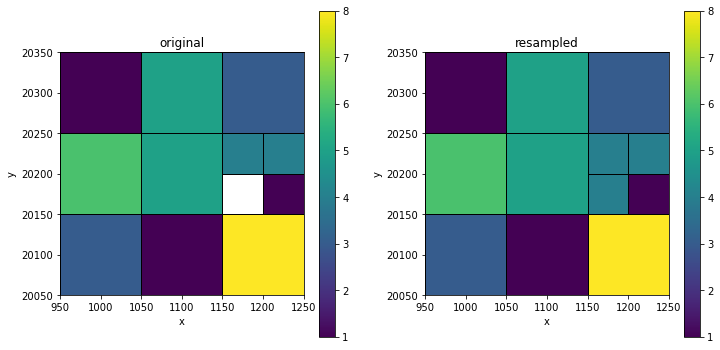

In [34]:
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                                        vmin=vertex1_nan.min(), vmax=vertex1_nan.max());
axes[0].set_aspect('equal')
axes[0].set_title('original')
nlmod.visualise.plots.plot_vertex_array(vertex1_nan_filled, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'})
axes[1].set_title('resampled')

### linear

In [35]:
vertex1_nan_filled_lin = resample.fillnan_dataarray_vertex_grid(vertex1_nan, x=xvc, y=yvc, icell2d=vertex1_nan.icell2d, method='linear')

Text(0.5, 1.0, 'resampled')

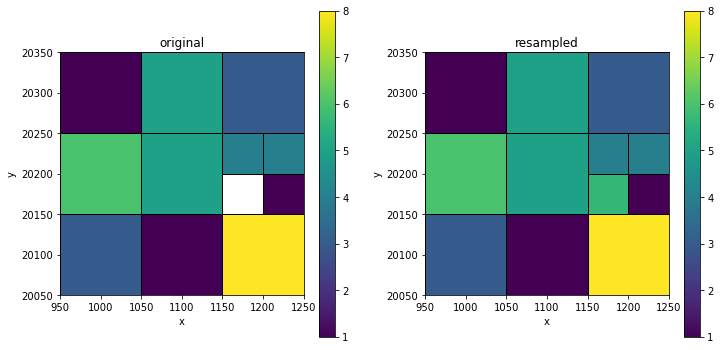

In [36]:
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                                        vmin=vertex1_nan.min(), vmax=vertex1_nan.max());
axes[0].set_aspect('equal')
axes[0].set_title('original')
nlmod.visualise.plots.plot_vertex_array(vertex1_nan_filled_lin, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'})
axes[1].set_title('resampled')

## [6. Vector to grid](#TOC)<a name="5"></a>

Vector data can be points, lines or polygons often saved as shapefiles and visualised using GIS software. A common operation is to project vector data on a modelgrid. For example to add a surface water line to a grid. Here are some functions in `nlmod` to project vector data on a modelgrid.

Vector data:
    - point
    - line
    - polygon

Vector data -> vector data per cell -> aggregeren per cell -> in het grid zetten

In [37]:
point_geom = [Point(x,y) for x, y in zip([1000, 1200, 1225, 1300],[20200, 20175, 20175, 20425])]
point_gdf = gpd.GeoDataFrame({'values':[1,52,66,24]}, geometry=point_geom)
line_geom = [LineString([point_geom[0], point_geom[1]]), LineString([point_geom[2], point_geom[3]]), LineString([point_geom[0], point_geom[3]])]
line_gdf = gpd.GeoDataFrame({'values':[1,52,66]}, geometry=line_geom)
pol_geom = [shp_polygon([point_geom[0], point_geom[1], point_geom[2], point_geom[3], point_geom[0]]),
            shp_polygon([point_geom[0], point_geom[1], point_geom[2], Point(1200,20300), point_geom[0]])]
pol_gdf = gpd.GeoDataFrame({'values':[166, 5]}, geometry=pol_geom)


(20050.0, 20500.0)

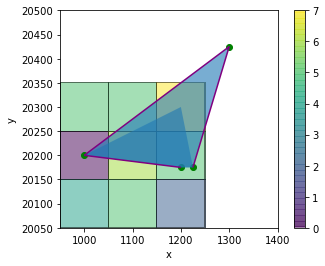

In [38]:
fig, ax = plt.subplots()
struc2d.plot(ax=ax, lw=0.1, edgecolor='k', alpha=0.5)
point_gdf.plot(ax=ax, color='green')
line_gdf.plot(ax=ax, color='purple')
pol_gdf.plot(ax=ax, alpha=0.6)

ax.set_xlim(ax.get_xlim()[0], 1400)
ax.set_ylim(ax.get_ylim()[0], 20500)

## Points

In [39]:
sim = flopy.mf6.MFSimulation()
gwf = flopy.mf6.MFModel(sim)
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=1, nrow=3, ncol=3, delr=100, delc=100, xorigin=950,yorigin=20050)

### Aggregation methods

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.56it/s]


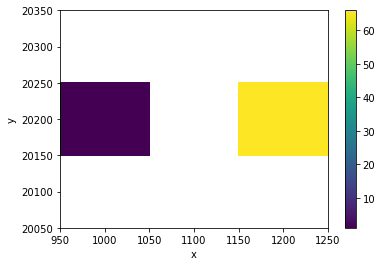

In [40]:
da = nlmod.mdims.gdf2data_array_struc(point_gdf, gwf, field='values', agg_method='max')
da.plot()

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.57it/s]


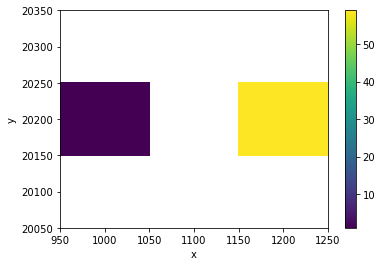

In [41]:
da = nlmod.mdims.gdf2data_array_struc(point_gdf, gwf, field='values', agg_method='mean')
da.plot()

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 199.84it/s]


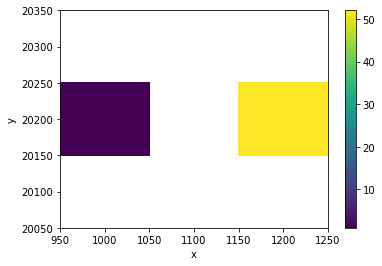

In [42]:
da = nlmod.mdims.gdf2data_array_struc(point_gdf, gwf, field='values', agg_method='nearest')
da.plot()

### Interpolation methods

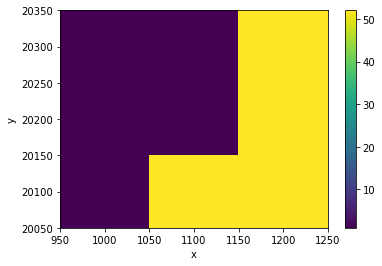

In [43]:
da = nlmod.mdims.gdf2data_array_struc(point_gdf, gwf, field='values', interp_method='nearest')
da.plot()

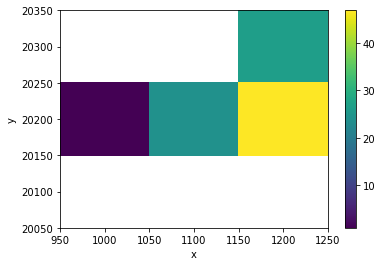

In [44]:
da = nlmod.mdims.gdf2data_array_struc(point_gdf, gwf, field='values', interp_method='linear')
da.plot()

## Lines

Aggregate vector data: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1001.65it/s]


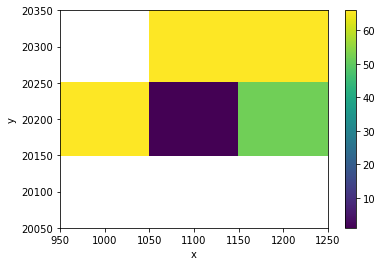

In [45]:
da = nlmod.mdims.gdf2data_array_struc(line_gdf, gwf, field='values', agg_method='max_length')
da.plot()

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 358.00it/s]


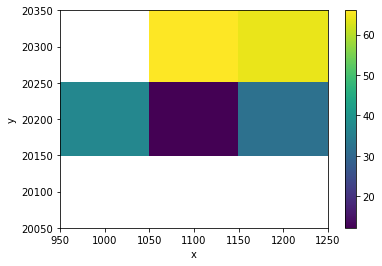

In [46]:
da = nlmod.mdims.gdf2data_array_struc(line_gdf, gwf, field='values', agg_method='length_weighted')
da.plot()

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.86it/s]


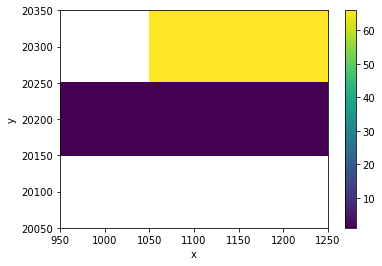

In [47]:
da = nlmod.mdims.gdf2data_array_struc(line_gdf, gwf, field='values', agg_method='nearest')
da.plot()

## Polygons

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 995.09it/s]


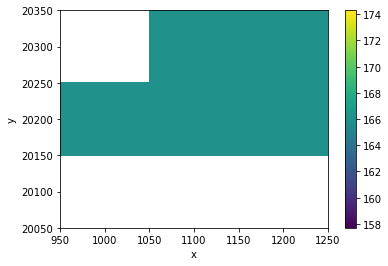

In [48]:
da = nlmod.mdims.gdf2data_array_struc(pol_gdf, gwf, field='values', agg_method='max_area')
da.plot()

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 295.08it/s]


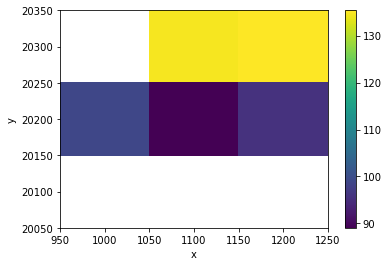

In [49]:
da = nlmod.mdims.gdf2data_array_struc(pol_gdf, gwf, field='values', agg_method='area_weighted')
da.plot()

Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 313.36it/s]


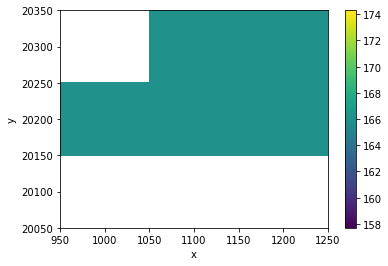

In [50]:
da = nlmod.mdims.gdf2data_array_struc(pol_gdf, gwf, field='values', agg_method='nearest')
da.plot()

## Intersect vector data with grid

In [51]:
gdf_point_grid = nlmod.mdims.gdf2grid(point_gdf, gwf)
gdf_line_grid = nlmod.mdims.gdf2grid(line_gdf, gwf)
gdf_pol_grid = nlmod.mdims.gdf2grid(pol_gdf, gwf)

Intersecting with grid: 100%|███████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.12it/s]


(950.0, 1300.0)

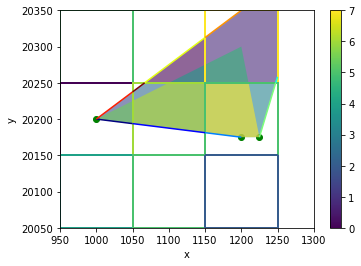

In [52]:
fig, ax = plt.subplots()

gdf_point_grid.plot(ax=ax, color='green')
gdf_line_grid['ind'] = range(gdf_line_grid.shape[0])
gdf_line_grid.plot('ind', ax=ax, cmap='jet')
gdf_pol_grid['ind'] = range(gdf_pol_grid.shape[0])
gdf_pol_grid.plot('ind',ax=ax, alpha=0.6)

struc2d.plot(ax=ax, facecolor='none', edgecolor='k')
ax.set_xlim(ax.get_xlim()[0], 1300)

## Aggregate parameters per model cell

Aggregatie options:
- point: max, min, mean
- line: max, min, length_weighted, max_length
- polygon: max, min, area_weighted, area_max


In [53]:
# point
display(gdf_point_grid)
nlmod.mdims.aggregate_vector_per_cell(gdf_point_grid,{'values':'max'})

,values,geometry,cellid
0,1,POINT (1000.000 20200.000),"(1, 0)"
1,52,POINT (1200.000 20175.000),"(1, 2)"
2,66,POINT (1225.000 20175.000),"(1, 2)"


Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 495.69it/s]


values
1 0     1.0
  2    66.0

In [54]:
# line
display(gdf_line_grid)
nlmod.mdims.aggregate_vector_per_cell(gdf_line_grid,{'values':'length_weighted'})

,values,geometry,cellid,ind
0,1,"LINESTRING (1000.000 20200.000, 1050.000 20193...","(1, 0)",0
0,1,"LINESTRING (1050.000 20193.750, 1150.000 20181...","(1, 1)",1
0,1,"LINESTRING (1150.000 20181.250, 1200.000 20175...","(1, 2)",2
1,52,"LINESTRING (1247.500 20250.000, 1250.000 20258...","(0, 2)",3
1,52,"LINESTRING (1225.000 20175.000, 1247.500 20250...","(1, 2)",4
2,66,"LINESTRING (1066.667 20250.000, 1150.000 20312...","(0, 1)",5
2,66,"LINESTRING (1150.000 20312.500, 1200.000 20350...","(0, 2)",6
2,66,"LINESTRING (1000.000 20200.000, 1050.000 20237...","(1, 0)",7
2,66,"LINESTRING (1050.000 20237.500, 1066.667 20250...","(1, 1)",8


Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 455.81it/s]


values
0 1  66.000000
  2  64.289282
1 0  36.986642
  1  12.135181
  2  32.030954

In [55]:
# polygon
display(gdf_pol_grid)
nlmod.mdims.aggregate_vector_per_cell(gdf_pol_grid,{'values':'area_weighted'})

,values,geometry,cellid,ind
0,166,"POLYGON ((1066.667 20250.000, 1150.000 20312.5...","(0, 1)",0
0,166,"POLYGON ((1250.000 20258.333, 1247.500 20250.0...","(0, 2)",1
0,166,"POLYGON ((1050.000 20193.750, 1000.000 20200.0...","(1, 0)",2
0,166,"POLYGON ((1150.000 20181.250, 1050.000 20193.7...","(1, 1)",3
0,166,"POLYGON ((1247.500 20250.000, 1225.000 20175.0...","(1, 2)",4
1,5,"POLYGON ((1100.000 20250.000, 1150.000 20275.0...","(0, 1)",5
1,5,"POLYGON ((1150.000 20275.000, 1200.000 20300.0...","(0, 2)",6
1,5,"POLYGON ((1050.000 20193.750, 1000.000 20200.0...","(1, 0)",7
1,5,"POLYGON ((1150.000 20181.250, 1050.000 20193.7...","(1, 1)",8
1,5,"POLYGON ((1210.000 20250.000, 1225.000 20175.0...","(1, 2)",9


Aggregate vector data: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 357.10it/s]


values
0 1  134.838710
  2  135.390494
1 0   98.916667
  1   89.061947
  2   95.590529